In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_california_housing
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from tensorflow import keras
import tensorflow as tf
from scikeras.wrappers import KerasClassifier, KerasRegressor

In [2]:
housing = fetch_california_housing()

In [3]:
X_train_full, X_test, y_train_full,  y_test = train_test_split(housing.data, housing.target, test_size=0.2)

In [4]:
X_train, X_val, y_train,  y_val = train_test_split(X_train_full, y_train_full, test_size=0.2)

In [5]:
scaler = StandardScaler()

In [6]:
X_train = scaler.fit_transform(X_train)
X_val = scaler.transform(X_val)
X_test = scaler.transform(X_test)

In [7]:
X_train.shape, X_test.shape

((13209, 8), (4128, 8))

In [8]:
model = keras.models.Sequential([
    keras.layers.Dense(30, activation='relu',
                      input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

model.compile(loss='mean_squared_error', optimizer='sgd')

In [9]:
history = model.fit(X_train, y_train, epochs=20,
                   validation_data=(X_val, y_val))

Epoch 1/20
413/413 [==============================] - 0s 517us/step - loss: 0.8171 - val_loss: 0.5915
Epoch 2/20
413/413 [==============================] - 0s 399us/step - loss: 0.8946 - val_loss: 0.4762
Epoch 3/20
413/413 [==============================] - 0s 398us/step - loss: 0.4406 - val_loss: 0.4334
Epoch 4/20
413/413 [==============================] - 0s 394us/step - loss: 0.4197 - val_loss: 0.4137
Epoch 5/20
413/413 [==============================] - 0s 397us/step - loss: 0.4089 - val_loss: 0.4061
Epoch 6/20
413/413 [==============================] - 0s 438us/step - loss: 0.4006 - val_loss: 0.4031
Epoch 7/20
413/413 [==============================] - 0s 394us/step - loss: 0.3961 - val_loss: 0.3927
Epoch 8/20
413/413 [==============================] - 0s 393us/step - loss: 0.3913 - val_loss: 0.3920
Epoch 9/20
413/413 [==============================] - 0s 393us/step - loss: 0.3879 - val_loss: 0.4017
Epoch 10/20
413/413 [==============================] - 0s 392us/step - loss: 0.383

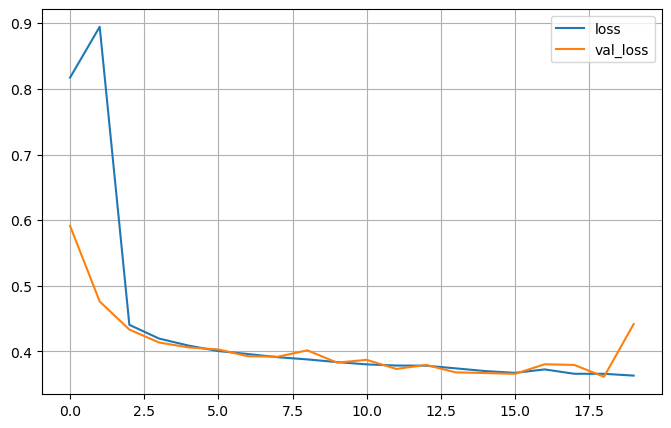

In [10]:
pd.DataFrame(history.history).plot(figsize=(8,5))
plt.grid();

In [11]:
model.evaluate(X_test, y_test)

129/129 [==============================] - 0s 288us/step - loss: 0.3403


0.3402526080608368

In [12]:
y_pred = model.predict(X_test)

129/129 [==============================] - 0s 276us/step


In [13]:
y_pred

array([[1.6601471],
       [1.369854 ],
       [1.8709762],
       ...,
       [3.8109612],
       [3.3668013],
       [1.6656563]], dtype=float32)

## GridSearchCV

In [14]:
def build_model(n_hidden, n_neurons, input_shape=[8]):
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=input_shape))
    for layer in range(n_hidden):
        model.add(keras.layers.Dense(n_neurons, activation='relu'))
    model.add(keras.layers.Dense(1))
    return model

In [15]:
keras_reg = KerasRegressor(build_model,
                           loss="mse",
                           metrics=[KerasRegressor.r_squared],
                           optimizer="adam",
                           optimizer__learning_rate=0.1,
                           model__n_hidden=1,
                           model__n_neurons=30)

In [16]:
keras_reg.fit(X_train, y_train, epochs=20,
             callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/20
413/413 [==============================] - 0s 354us/step - loss: 4.1224 - r_squared: -2.3055
Epoch 2/20
413/413 [==============================] - 0s 344us/step - loss: 274.8712 - r_squared: -161.5248
Epoch 3/20
413/413 [==============================] - 0s 348us/step - loss: 645.2324 - r_squared: -637.2365
Epoch 4/20
413/413 [==============================] - 0s 382us/step - loss: 141.0981 - r_squared: -108.0319
Epoch 5/20
413/413 [==============================] - 0s 342us/step - loss: 15.4515 - r_squared: -13.0112
Epoch 6/20
413/413 [==============================] - 0s 343us/step - loss: 1.4728 - r_squared: -0.3689
Epoch 7/20
413/413 [==============================] - 0s 343us/step - loss: 1.9832 - r_squared: -0.6123
Epoch 8/20
413/413 [==============================] - 0s 342us/step - loss: 42.8053 - r_squared: -31.9599
Epoch 9/20
413/413 [==============================] - 0s 340us/step - loss: 99.1164 - r_squared: -73.2541
Epoch 10/20
413/413 [=========================

KerasRegressor(
	model=<function build_model at 0x14bacd700>
	build_fn=None
	warm_start=False
	random_state=None
	optimizer=adam
	loss=mse
	metrics=[<function KerasRegressor.r_squared at 0x14babaaf0>]
	batch_size=None
	validation_batch_size=None
	verbose=1
	callbacks=None
	validation_split=0.0
	shuffle=True
	run_eagerly=False
	epochs=1
	optimizer__learning_rate=0.1
	model__n_hidden=1
	model__n_neurons=30
)

In [17]:
keras_reg.score(X_test, y_test)

129/129 [==============================] - 0s 287us/step


0.6183664841459809

In [18]:
params = {
    'model__n_hidden': [1, 2, 3],
    'model__n_neurons': np.arange(30, 100),
    'optimizer__learning_rate': [3e-1, 2e-1, 1e-1]
}

In [19]:
grid = GridSearchCV(keras_reg, params, cv=3)

In [ ]:
grid.fit(X_train, y_train, epochs=20,
              validation_data=(X_val, y_val),
             callbacks=[keras.callbacks.EarlyStopping(patience=10)])

Epoch 1/20
276/276 [==============================] - 0s 643us/step - loss: 307.3984 - r_squared: -263.4290 - val_loss: 12.9315 - val_r_squared: -9.1967
Epoch 2/20
276/276 [==============================] - 0s 543us/step - loss: 2.3827 - r_squared: -0.9575 - val_loss: 1.2869 - val_r_squared: -0.0022
Epoch 3/20
276/276 [==============================] - 0s 479us/step - loss: 0.9074 - r_squared: 0.3081 - val_loss: 0.6120 - val_r_squared: 0.5250
Epoch 4/20
276/276 [==============================] - 0s 484us/step - loss: 0.5932 - r_squared: 0.5401 - val_loss: 0.6027 - val_r_squared: 0.5365
Epoch 5/20
276/276 [==============================] - 0s 484us/step - loss: 0.5753 - r_squared: 0.5542 - val_loss: 0.4886 - val_r_squared: 0.6294
Epoch 6/20
276/276 [==============================] - 0s 479us/step - loss: 0.6650 - r_squared: 0.4780 - val_loss: 0.7279 - val_r_squared: 0.4357
Epoch 7/20
276/276 [==============================] - 0s 476us/step - loss: 0.5886 - r_squared: 0.5378 - val_loss: 

In [ ]:
grid.best_params_

In [ ]:
grid.score(X_test, y_test)